# Decision boundaries usign Supervised decision boundary maps (SDBM)

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import tqdm

from itertools import permutations
from sklearn.utils.extmath import cartesian

import torch
import torch.nn as nn
import torch.nn.functional as F

from NegativeClassOptimization import decision_boundaries, config, visualisations
from NegativeClassOptimization import utils
from NegativeClassOptimization import preprocessing
from NegativeClassOptimization import datasets

from NegativeClassOptimization.decision_boundaries import compute_decision_boundary_coords, rotate

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [3]:
def get_model_from_task(task):
    if type(task.model) == torch.optim.swa_utils.AveragedModel:
    # Unwrap the SWA model. We need a module class,
    # that has updated weights, but still has other
    # module funcs, such as forward_logits.
    # Note: swa_model.module has same weights as swa_model.state_dict().
        return task.model.module
    else:
        return task.model

In [4]:
loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
)

# task = datasets.ClassificationTask(
#         task_type=datasets.ClassificationTaskType.ONE_VS_ONE,
#         ag_pos="3VRL",
#         ag_neg="1NSN",
#         seed_id=0,
#         split_id=42,
#     )

# TEST: curved boundary
# task = datasets.ClassificationTask(
#         task_type=datasets.ClassificationTaskType.ONE_VS_ONE,
#         ag_pos="1ADQ",
#         ag_neg="2YPV",
#         seed_id=0,
#         split_id=42,
#     )

# task = datasets.ClassificationTask(
#         task_type=datasets.ClassificationTaskType.HIGH_VS_95LOW,
#         ag_pos="3VRL",
#         ag_neg="auto",
#         seed_id=0,
#         split_id=42,
#     )


# task = datasets.ClassificationTask(
#         task_type=datasets.ClassificationTaskType.HIGH_VS_LOOSER,
#         ag_pos="3VRL",
#         ag_neg="auto",
#         seed_id=0,
#         split_id=42,
#     )

task = datasets.ClassificationTask(
        task_type=datasets.ClassificationTaskType.HIGH_VS_LOOSER,
        ag_pos="3RAJ",
        ag_neg="auto",
        seed_id=0,
        split_id=42,
    )

task = loader.load(task, attributions_toload="v2.0-2", load_model=True)

In [15]:
# Load performance metrics
df_id = pd.read_csv("../data/closed_performance.tsv", sep='\t')
df_id["task_type"] = df_id["task"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
df_id["ag_pos"] = df_id["task"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).ag_pos)
df_id["ag_neg"] = df_id["task"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).ag_neg)
df_id["seed_id"] = df_id["task"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).seed_id)
df_id["split_id"] = df_id["task"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).split_id)

df_rd_logits = pd.read_csv(
    "../data/Frozen_MiniAbsolut_ML/07e_LogitEnergyCorrelations_final.tsv",
)
df_rd_logits["corr_logits"] = df_rd_logits["r_pos"]

df_rd_attr = pd.read_csv(
    "../data/Frozen_MiniAbsolut_ML/07e_EnergyContributions.tsv",
    sep='\t',
)
df_rd_attr["corr_attr"] = df_rd_attr["mean_pos_total"]

# Merge
on_cols = ["task_type", "ag_pos", "ag_neg", "seed_id", "split_id"]
df_perf = pd.merge(
    df_id[on_cols + ["acc", "task"]],
    df_rd_logits[on_cols + ["corr_logits"]], 
    on=on_cols,
    how="right",
)
df_perf = pd.merge(
    df_perf,
    df_rd_attr[on_cols + ["corr_attr"]],
    on=on_cols,
    how="right",
)
df_perf

,task_type,ag_pos,ag_neg,seed_id,split_id,acc,task,corr_logits,corr_attr
0,1v1,3VRL,1NSN,0,42,0.990500,ONE_VS_ONE__3VRL__1NSN__0__42,-0.585052,-0.597005
1,1v1,3VRL,3RAJ,0,42,0.972400,ONE_VS_ONE__3VRL__3RAJ__0__42,-0.334859,-0.404372
2,1v1,3VRL,5E94,0,42,0.984200,ONE_VS_ONE__3VRL__5E94__0__42,-0.151120,0.091077
3,1v1,3VRL,1H0D,0,42,0.991400,ONE_VS_ONE__3VRL__1H0D__0__42,-0.522465,-0.548198
4,1v1,3VRL,1WEJ,0,42,0.985600,ONE_VS_ONE__3VRL__1WEJ__0__42,-0.537149,-0.532763
...,...,...,...,...,...,...,...,...,...
355,high_vs_95low,1OB1,auto,0,3,0.988900,HIGH_VS_95LOW__1OB1__auto__0__3,-0.585123,-0.732303
356,high_vs_looser,1OB1,auto,0,3,0.918700,HIGH_VS_LOOSER__1OB1__auto__0__3,-0.702079,-0.720818
357,1v9,1OB1,auto,0,4,0.944472,ONE_VS_NINE__1OB1__auto__0__4,-0.371357,-0.498989
358,high_vs_95low,1OB1,auto,0,4,0.988000,HIGH_VS_95LOW__1OB1__auto__0__4,-0.548172,-0.703149


In [25]:
task.test_dataset = preprocessing.onehot_encode_df(task.test_dataset)
task.test_dataset["X"] = task.test_dataset["Slide_onehot"]

X = np.stack(task.test_dataset["X"])
y = task.test_dataset["y"].astype(float)

In [26]:
# Based on experiment_blobs.py

output_dir = Path("07i_decision_boundaries")
epochs = 30  # 30 200
patience = 5
verbose = False
dataset_name = f"{str(task)}_e{epochs}"


n_samples = X.shape[0]
n_classes = len(np.unique(y))

X_ssnpgt_proj_file = f'X_SSNP_{dataset_name}.npy'
name_projector_ssnp = f"{dataset_name}_ssnp"

ssnpgt = decision_boundaries.SSNP(
    epochs=epochs, 
    verbose=verbose, 
    patience=patience, 
    opt='adam', 
    bottleneck_activation='linear'
)

if (output_dir / name_projector_ssnp).exists():
    ssnpgt.load_model(output_dir / name_projector_ssnp)
else: #otherwise it will be fitted
    ssnpgt.fit(X, y)
    ssnpgt.save_model(output_dir / name_projector_ssnp)

INFO:tensorflow:Assets written to: 07i_decision_boundaries/HIGH_VS_LOOSER__3RAJ__auto__0__42_e200_ssnp/assets


In [27]:
if os.path.exists(os.path.join(output_dir, X_ssnpgt_proj_file)):
    print(
        f"Projected SSNP points found! {os.path.join(output_dir,X_ssnpgt_proj_file)}"
    )
    X_ssnpgt = np.load(os.path.join(output_dir, X_ssnpgt_proj_file))
else:
    print("Projected SSNP points not found! Transforming...")
    X_ssnpgt = ssnpgt.transform(X)
    np.save(os.path.join(output_dir, X_ssnpgt_proj_file), X_ssnpgt)
    print(f"Projected points ({dataset_name}) saved.")

Projected SSNP points not found! Transforming...
Projected points (HIGH_VS_LOOSER__3RAJ__auto__0__42_e200) saved.


In [28]:
clf = get_model_from_task(task)
clf_name = "SN10"
grid_size = 300

force = True
ssnp_done = False
out_name = f"{clf_name}_{grid_size}x{grid_size}_{dataset_name}"
out_file = os.path.join(output_dir, out_name + "_ssnp.npy")

if os.path.exists(out_file) and not force:
    img_grid_ssnp = np.load(
        os.path.join(output_dir, out_name + "_ssnp.npy")
    )
    prob_grid_ssnp = np.load(
        os.path.join(output_dir, out_name + "_ssnp_prob" + ".npy")
    )
    prob_grid_ssnp = prob_grid_ssnp.clip(max=0.8)

    # Background mode
    normalized = None
    suffix = "ssnp_background"

    imgs = decision_boundaries.results_to_png(
        np_matrix=img_grid_ssnp,
        prob_matrix=prob_grid_ssnp,
        grid_size=grid_size,
        n_classes=n_classes,
        real_points=normalized,
        max_value_hsv=0.8,
        dataset_name=dataset_name,
        classifier_name=clf_name,
        suffix=suffix,
        output_dir=output_dir,
    )

else:

    print("Defining grid around projected 2D points.")
    xmin_ssnp = np.min(X_ssnpgt[:, 0])
    xmax_ssnp = np.max(X_ssnpgt[:, 0])
    ymin_ssnp = np.min(X_ssnpgt[:, 1])
    ymax_ssnp = np.max(X_ssnpgt[:, 1])

    x_intrvls_ssnp = np.linspace(xmin_ssnp, xmax_ssnp, num=grid_size)
    y_intrvls_ssnp = np.linspace(ymin_ssnp, ymax_ssnp, num=grid_size)

    x_grid = np.linspace(0, grid_size - 1, num=grid_size)
    y_grid = np.linspace(0, grid_size - 1, num=grid_size)

    pts_ssnp = cartesian((x_intrvls_ssnp, y_intrvls_ssnp))
    pts_grid = cartesian((x_grid, y_grid))
    pts_grid = pts_grid.astype(int)

    batch_size = min(grid_size**2, 10000)

    # Can probably be moved lower, here not used
    img_grid_ssnp = np.zeros((grid_size, grid_size))
    prob_grid_ssnp = np.zeros((grid_size, grid_size))

    pbar = tqdm.tqdm(total=len(pts_ssnp))
    position = 0

    # Iterate over all points in the 2D-grid 
    while True:
        if position >= len(pts_ssnp):
            break

        pts_batch_ssnp = pts_ssnp[position : position + batch_size]
        image_batch_ssnp = ssnpgt.inverse_transform(pts_batch_ssnp)

        probs_ssnp = clf.predict(torch.tensor(image_batch_ssnp)).detach().numpy()
        alpha_ssnp = np.amax(probs_ssnp, axis=1)
        labels_ssnp = probs_ssnp.argmax(axis=1)

        pts_grid_batch = pts_grid[position : position + batch_size]

        img_grid_ssnp[
            pts_grid_batch[:, 0],  # First column
            pts_grid_batch[:, 1],  # Second column
        ] = labels_ssnp

        position += batch_size

        prob_grid_ssnp[
            pts_grid_batch[:, 0],  # First column
            pts_grid_batch[:, 1],  # Second column
        ] = alpha_ssnp

        pbar.update(batch_size)

    pbar.close()
    np.save(os.path.join(output_dir, f"{out_name}_ssnp.npy"), img_grid_ssnp)
    np.save(
        os.path.join(output_dir, f"{out_name}_ssnp_prob.npy"), prob_grid_ssnp
    )

    prob_grid_ssnp = prob_grid_ssnp.clip(max=0.8)

    # Background mode
    normalized = None
    suffix = "ssnp_background"

    imgs = decision_boundaries.results_to_png(
        np_matrix=img_grid_ssnp,
        prob_matrix=prob_grid_ssnp,
        grid_size=grid_size,
        n_classes=n_classes,
        real_points=normalized,
        max_value_hsv=0.8,
        dataset_name=dataset_name,
        classifier_name=clf_name,
        suffix=suffix,
        output_dir=output_dir,
    )

Defining grid around projected 2D points.


100%|██████████| 90000/90000 [00:05<00:00, 15140.94it/s]


Saving vanilla. 300x300 - HIGH_VS_LOOSER__3RAJ__auto__0__42_e200 - SN10
Saving alpha. 300x300 - HIGH_VS_LOOSER__3RAJ__auto__0__42_e200 - SN10
Saving hsv. 300x300 - HIGH_VS_LOOSER__3RAJ__auto__0__42_e200 - SN10


We develop further the plot generation, to include the data points and color them. This will allow a better investigation of decision boundaries!

In [29]:
decision_boundary_coords = compute_decision_boundary_coords(clf, ssnpgt, X_ssnpgt, grid_size)

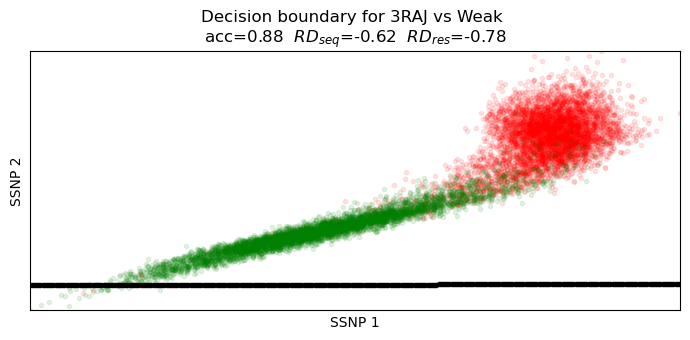

In [30]:
fig, ax = plt.subplots()

X_ssnpgt_neg = X_ssnpgt[np.where(y == 0.)]
X_ssnpgt_pos = X_ssnpgt[np.where(y == 1.)]

# Rotate the points according to the centroids of red and green
# so that they are as horizontal as possible.
# centroid_neg = np.mean(X_ssnpgt_neg, axis=0)
# centroid_pos = np.mean(X_ssnpgt_pos, axis=0)
# angle = math.degrees(math.atan2(centroid_neg[1] - centroid_pos[1], centroid_neg[0] - centroid_pos[0]))
# rotation_ax = (centroid_neg + centroid_pos) / 2 

# X_ssnpgt_rot_neg = rotate(X_ssnpgt_neg, origin=rotation_ax, degrees=-angle)
# X_ssnpgt_rot_pos = rotate(X_ssnpgt_pos, origin=rotation_ax, degrees=-angle)
# decision_boundary_coords_rot = rotate(decision_boundary_coords, origin=rotation_ax, degrees=-angle)

ax.plot(X_ssnpgt_neg[:, 0], X_ssnpgt_neg[:, 1], '.', color="red", alpha=0.1)
ax.plot(X_ssnpgt_pos[:, 0], X_ssnpgt_pos[:, 1], '.', color="green", alpha=0.1)
ax.plot(decision_boundary_coords[:, 0], decision_boundary_coords[:, 1], '.', color="black", alpha=0.9)


# X_ssnpgt_rot = np.concatenate([X_ssnpgt_rot_neg, X_ssnpgt_rot_pos])
ax.set_xlim(X_ssnpgt[:, 0].min(), X_ssnpgt[:, 0].max())
ax.set_ylim(X_ssnpgt[:, 1].min(), X_ssnpgt[:, 1].max())

# Extra
acc = df_perf.query("task == @task")["acc"]
rd_seq = df_perf.query("task == @task")["corr_logits"]
rd_res = df_perf.query("task == @task")["corr_attr"]
task_type_clean = visualisations.map_task_type_to_clean[task.task_type.to_str()]
ag_pos = task.ag_pos
ag_neg = task.ag_neg
if ag_neg == "auto":
    ag_neg = task_type_clean
elif ag_neg == "9":
    ag_neg = task_type_clean
else:
    ag_neg = f"vs {ag_neg}"

ax.set_title(
    f"Decision boundary for {ag_pos} {ag_neg} \nacc={acc.values[0]:.2f}  "
    + r"$RD_{seq}$=" + f"{rd_seq.values[0]:.2f}"
    + r"  $RD_{res}$=" + f"{rd_res.values[0]:.2f}"
)
ax.set_xlabel("SSNP 1")
ax.set_ylabel("SSNP 2")
ax.set_xticks([])
ax.set_yticks([])



# Print accuracies and task data!
# Run across all and aggregate, add to manuscript
# Consider adding energy gradient! :O might be extremly revealing the sorting

# Add rule learning?


fig.show()

We computed the above for all the tasks using script 17. Now we collect all the plots to check them.
Blue indicates positive class!

In [6]:
def task_generator(loader=loader):
    """
    Generate tasks for which to compute attributions.
    """
    task_types = [
        datasets.ClassificationTaskType.HIGH_VS_LOOSER,
        datasets.ClassificationTaskType.HIGH_VS_95LOW,
        datasets.ClassificationTaskType.ONE_VS_NINE,
        datasets.ClassificationTaskType.ONE_VS_ONE,
    ]
    seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
    for ag_1, ag_2 in permutations(config.ANTIGENS, r=2):
        for seed_id, split_id in seed_split_ids:
            for task_type in task_types:
                if task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
                    task = datasets.ClassificationTask(
                        task_type=task_type,
                        ag_pos=ag_1,
                        ag_neg=ag_2,
                        seed_id=seed_id,
                        split_id=split_id,
                    )
                else:
                    task = datasets.ClassificationTask(
                        task_type=task_type,
                        ag_pos=ag_1,
                        ag_neg="auto",
                        seed_id=seed_id,
                        split_id=split_id,
                    )
                yield task

tasks = list(task_generator())

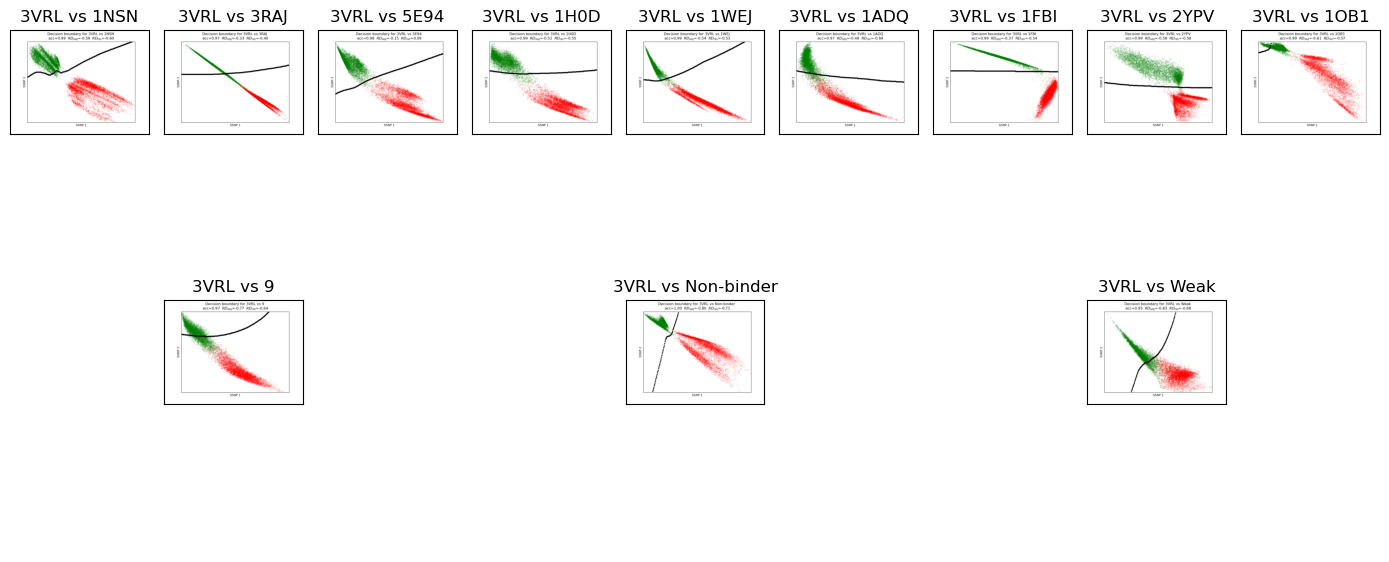

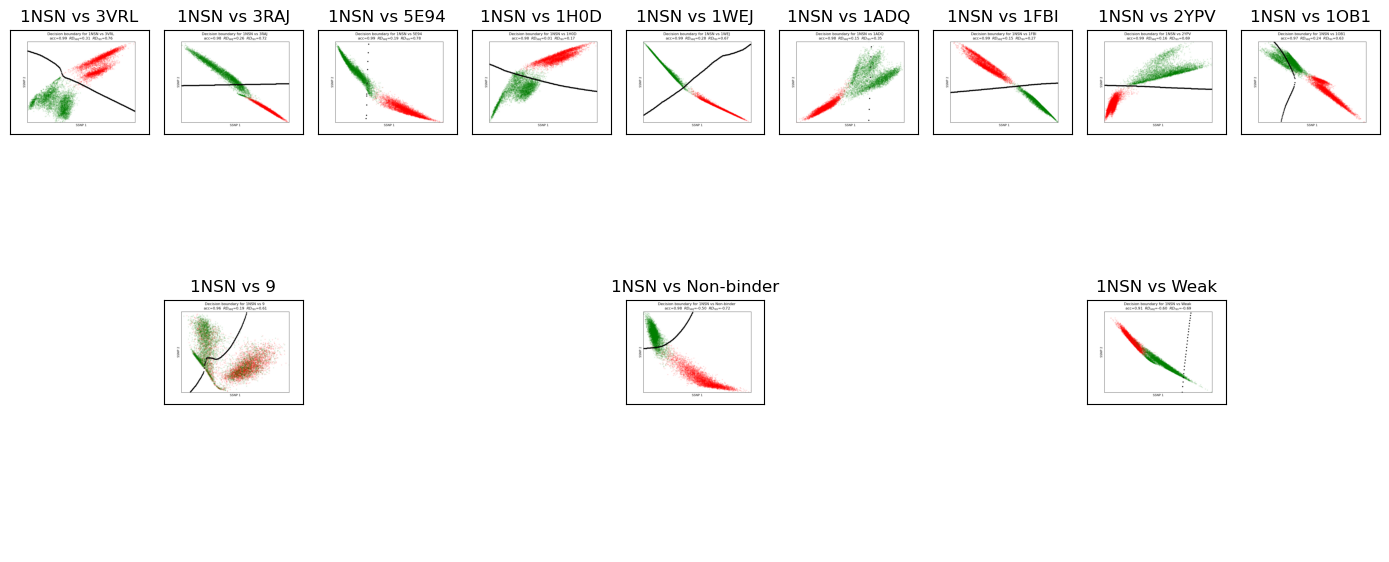

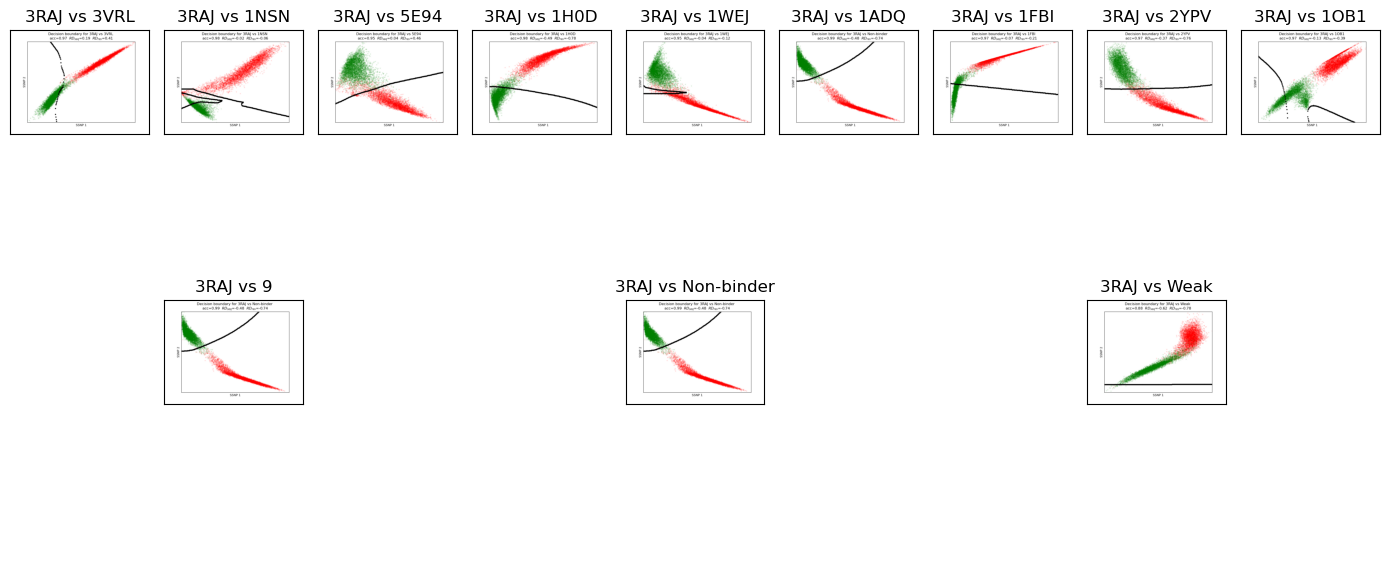

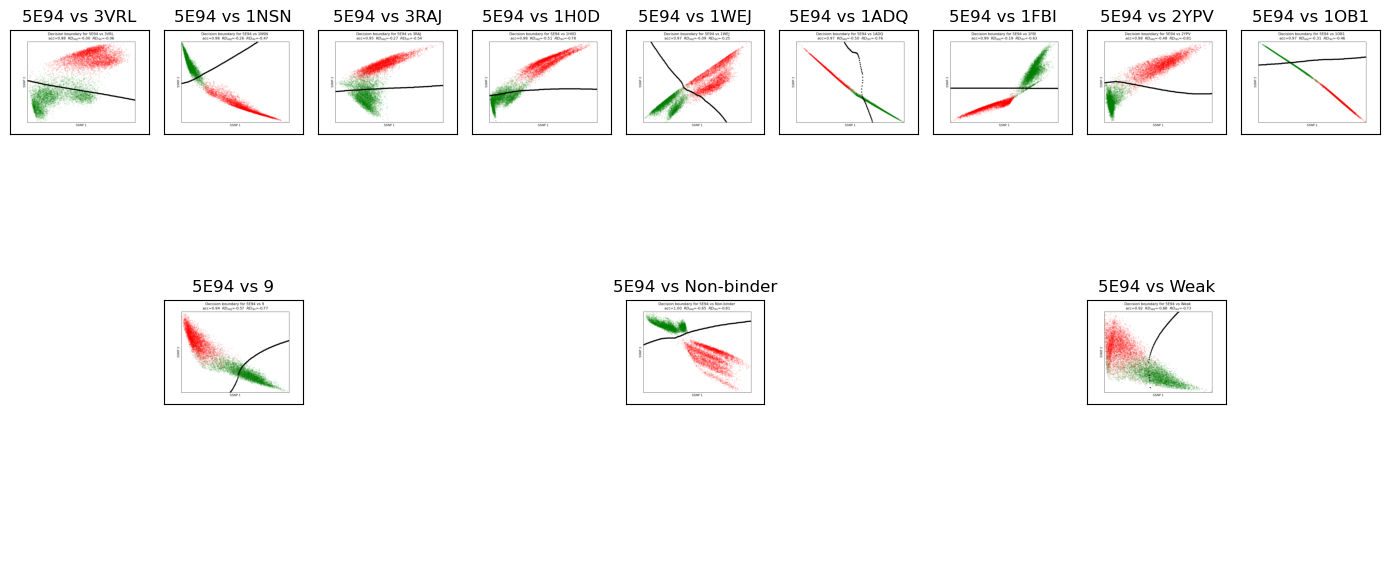

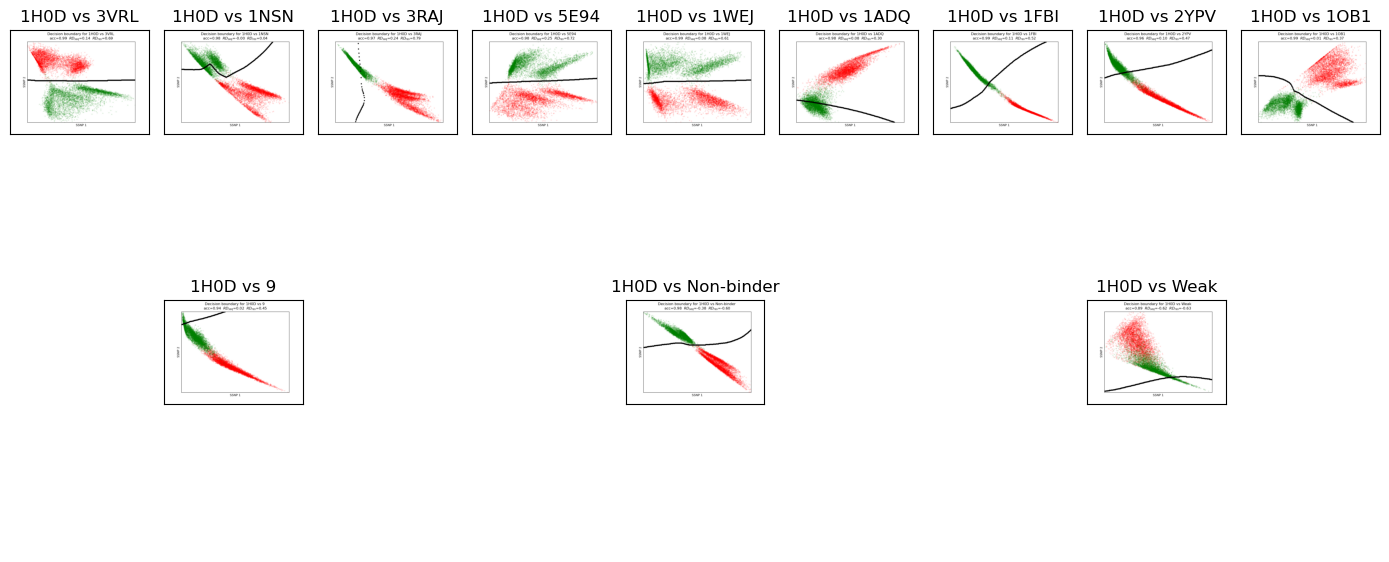

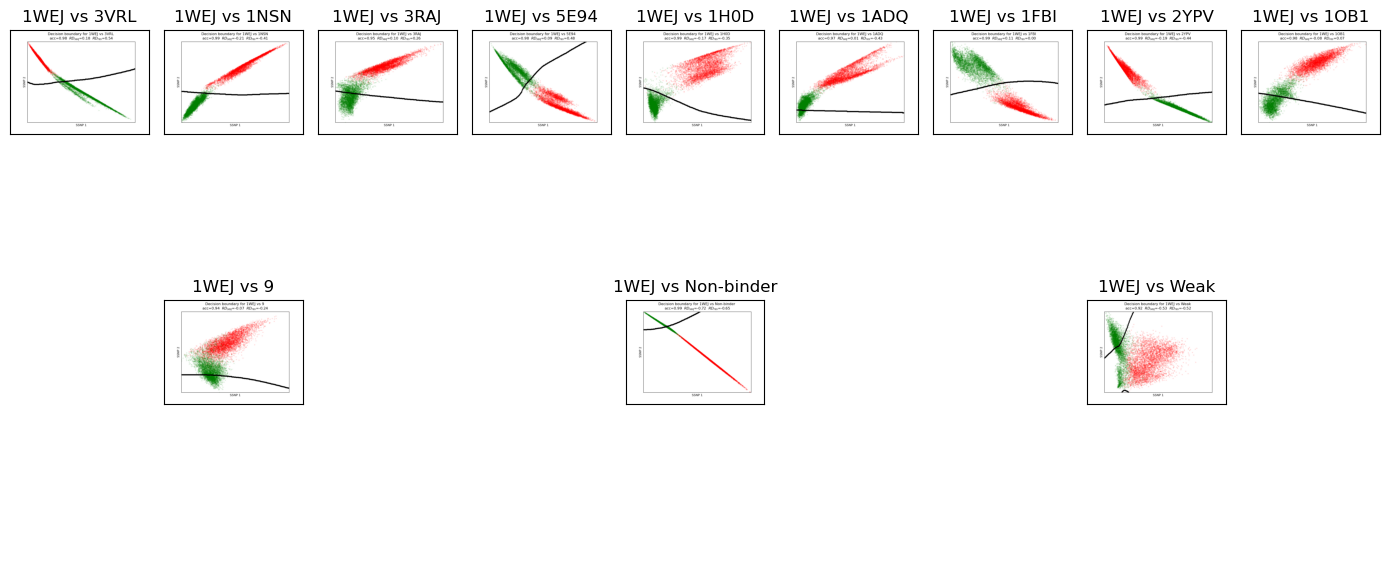

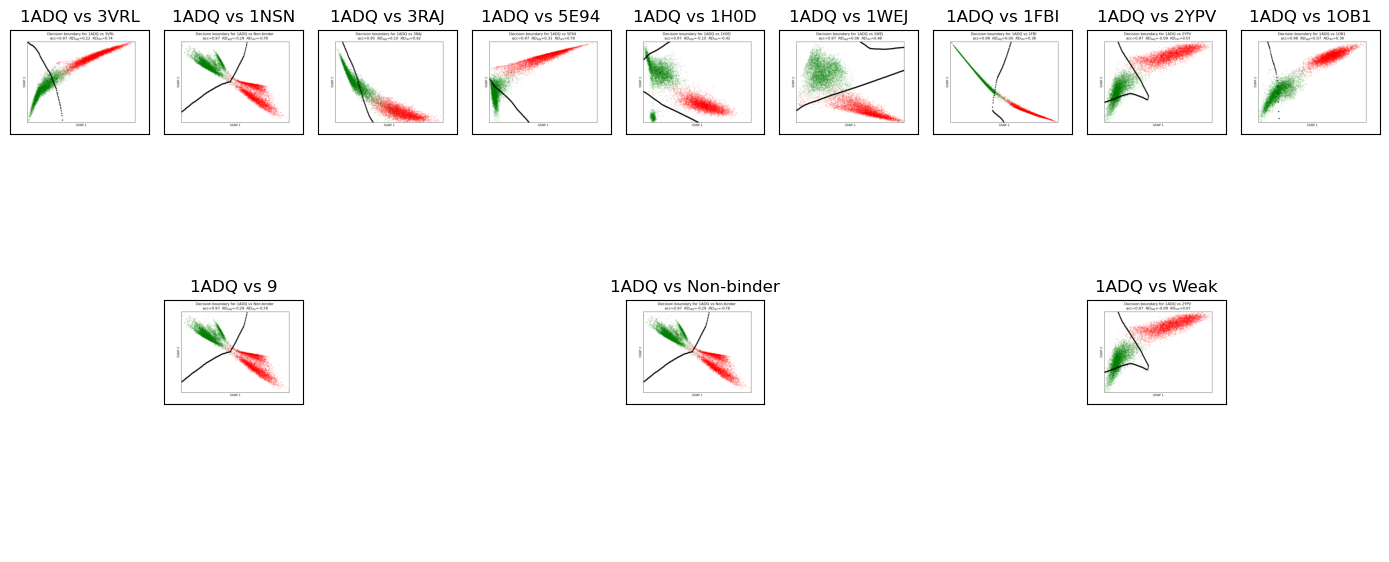

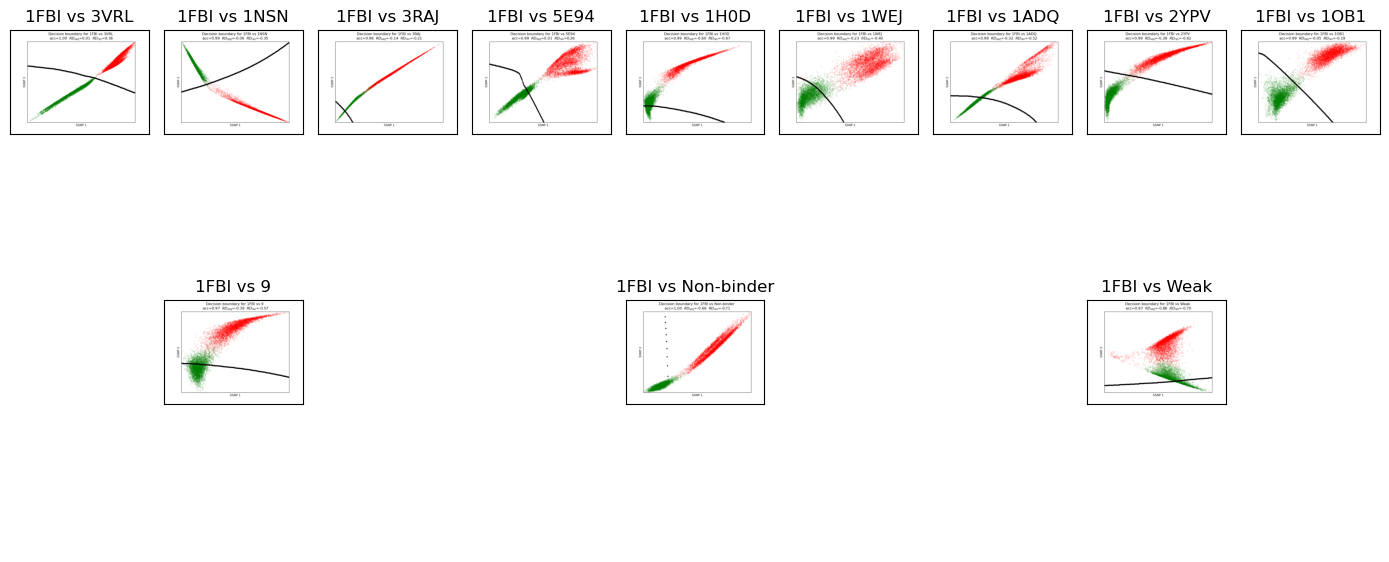

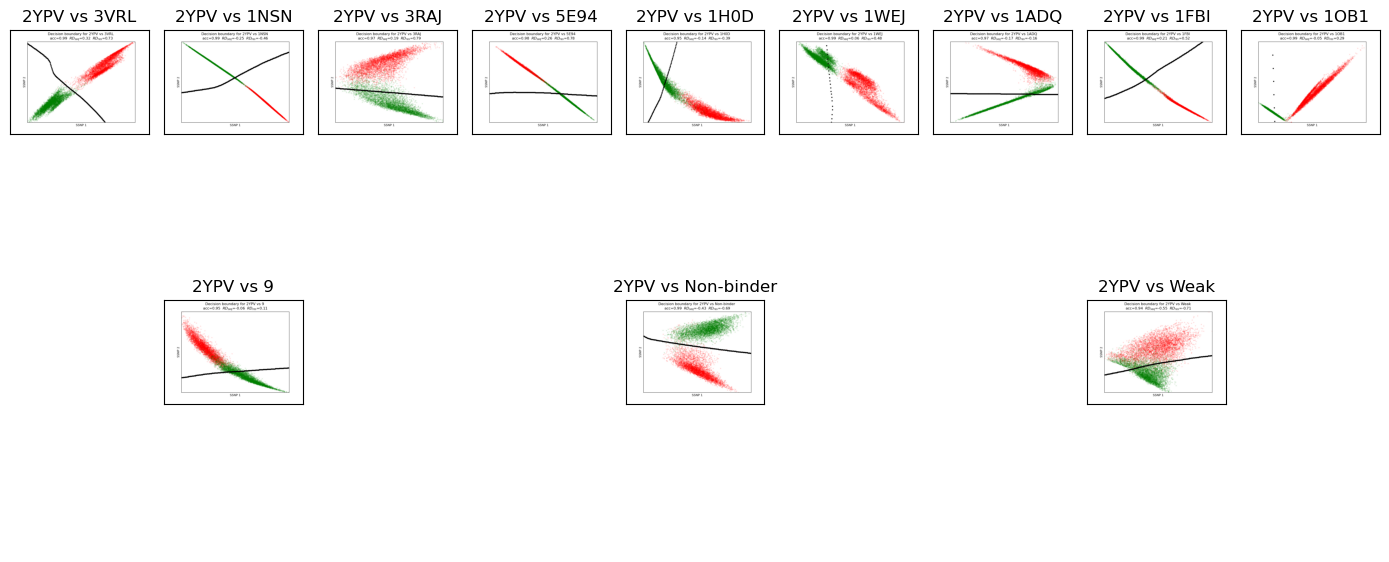

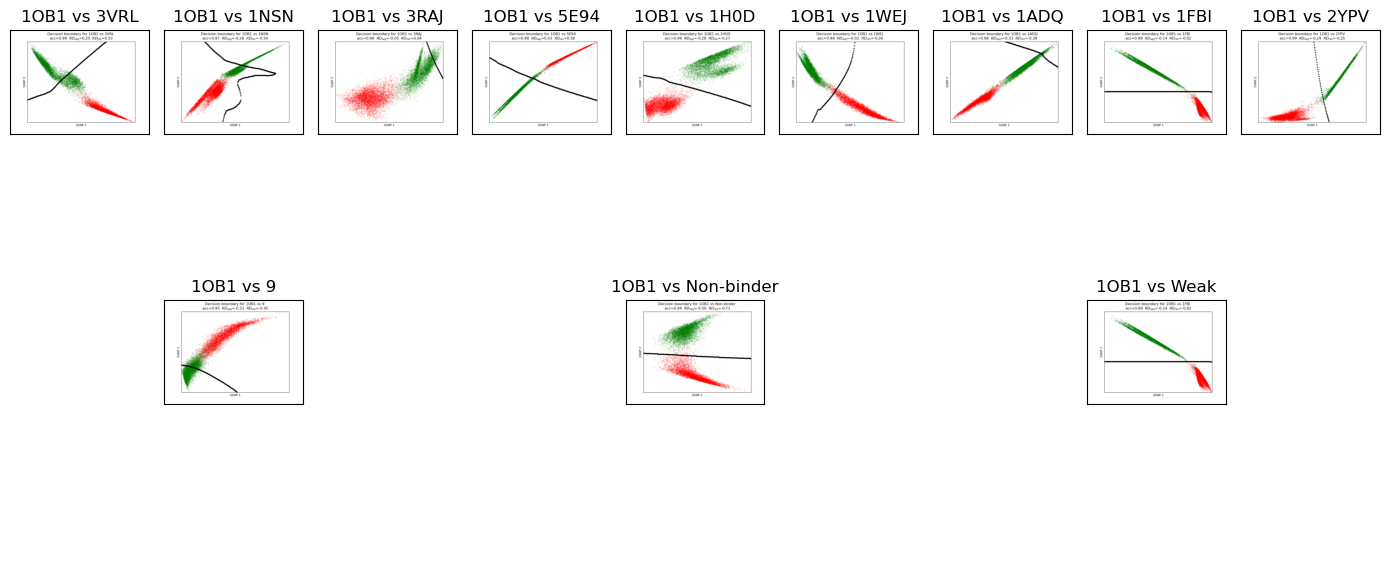

In [13]:
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams["figure.figsize"] = [7.00, 3.50] 
plt.rcParams["figure.autolayout"] = True

# PdfPages is a wrapper around pdf  
# file so there is no clash and 
# create files with no error. 
p = PdfPages("test2.pdf") 

tasks = list(filter(lambda t: t.seed_id == 0 and t.split_id == 42, tasks))

for ag in config.ANTIGENS:

    tasks_ag = filter(lambda t: t.ag_pos == ag, tasks)

    fig, axs = plt.subplots(nrows=2, ncols=9, figsize=(14, 7))

    counter_1v1 = 0
    for task in tasks_ag:

        task = loader.load(task)
        base_path = task.basepath
        img_path = base_path / "SDBM/SN10_300x300_SDBM_nice.png"
    
        if img_path.exists():
            img = plt.imread(img_path)

        # Select ax based on task_type
        if task.task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
            ax = axs[0, counter_1v1]
            counter_1v1 += 1
            title = f"{task.ag_pos} vs {task.ag_neg}"

        elif task.task_type == datasets.ClassificationTaskType.ONE_VS_NINE:
            ax = axs[1, 1]
            title = f"{task.ag_pos} vs 9"
        elif task.task_type == datasets.ClassificationTaskType.HIGH_VS_95LOW:
            ax = axs[1, 4]
            title = f"{task.ag_pos} vs Non-binder"
        elif task.task_type == datasets.ClassificationTaskType.HIGH_VS_LOOSER:
            ax = axs[1, 7]
            title = f"{task.ag_pos} vs Weak"

        # Figure from img
        ax.imshow(img)
        ax.set_title(title)

    # Make all the unused axes invisible
    for ax in axs.flatten():
        if not ax.get_title():
            ax.axis("off")
        else:
            ax.axis("on")

    # Remove x and y ticks and labels
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")

    # and saving the files 
    fig.savefig(p, format='pdf')
        
# close the object 
p.close()   

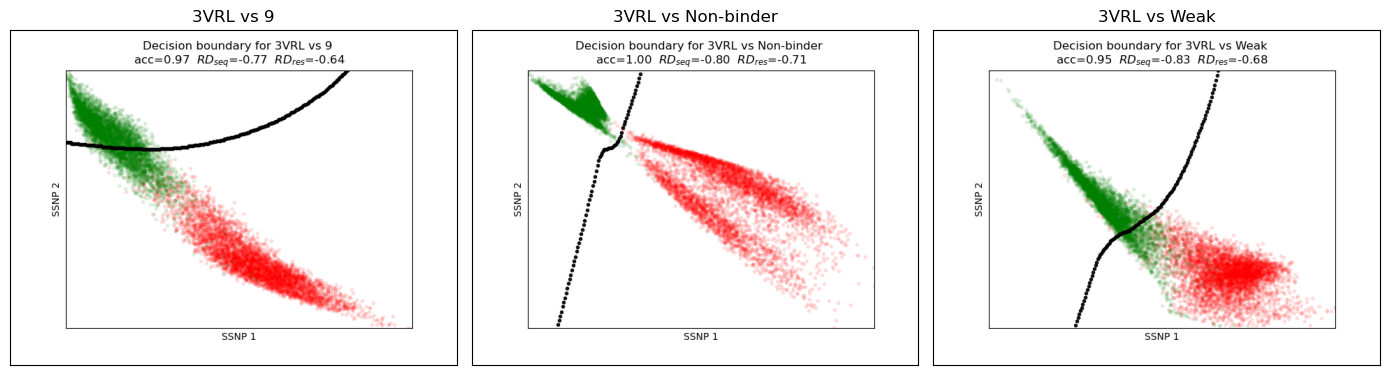

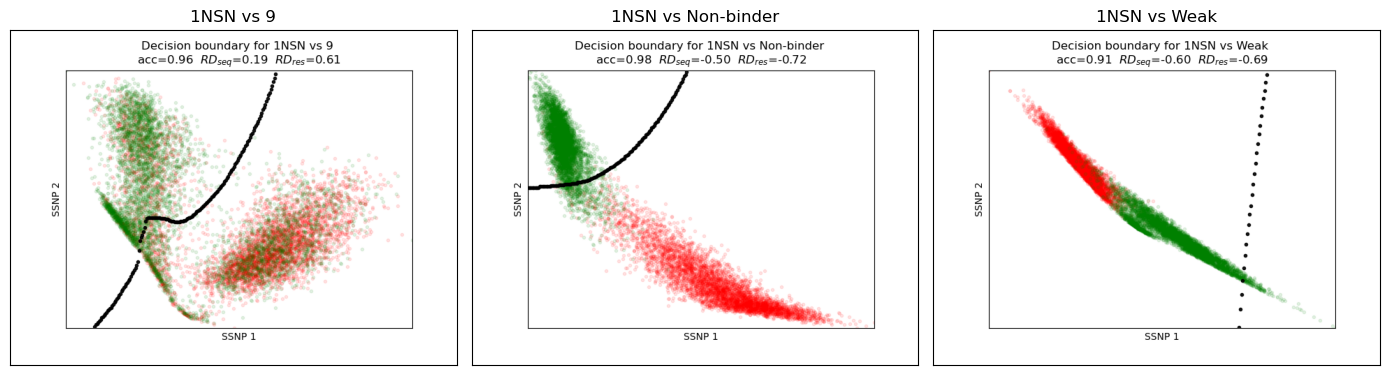

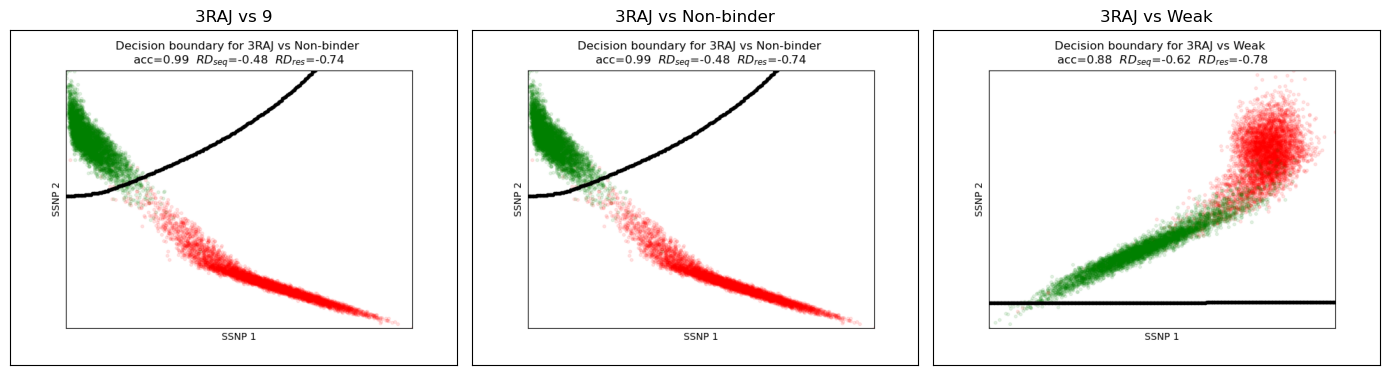

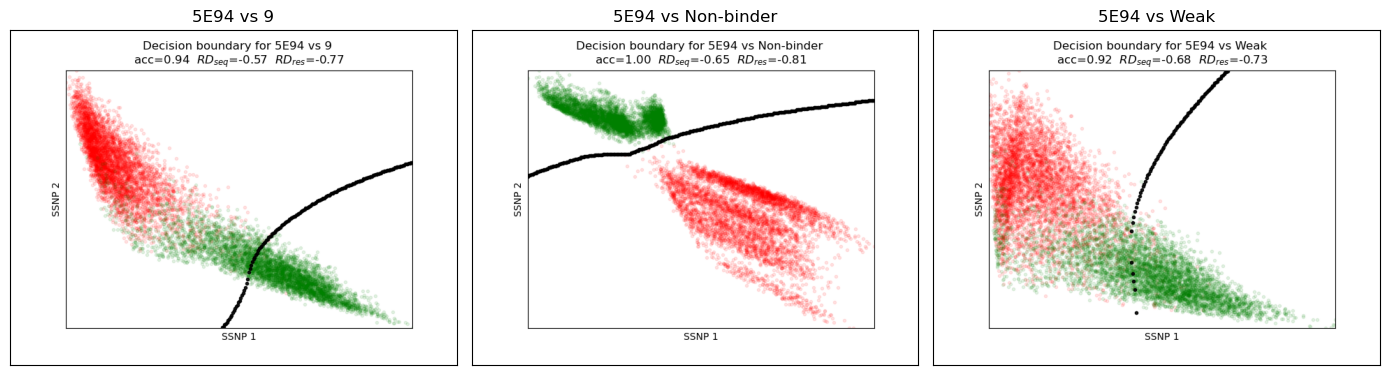

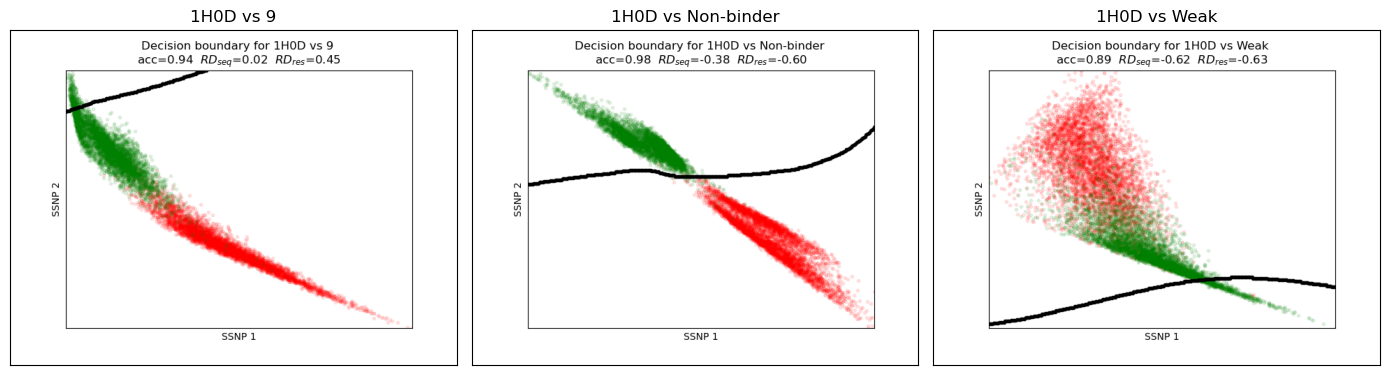

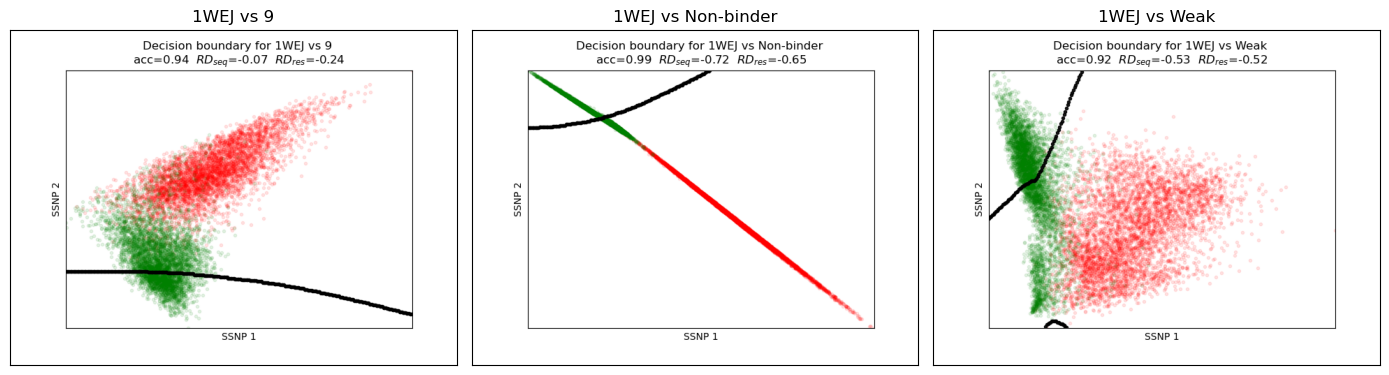

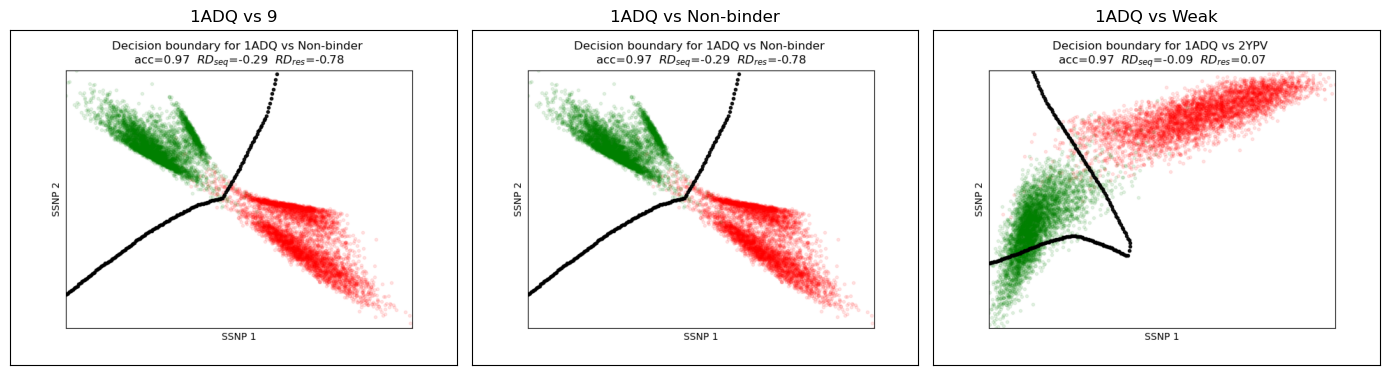

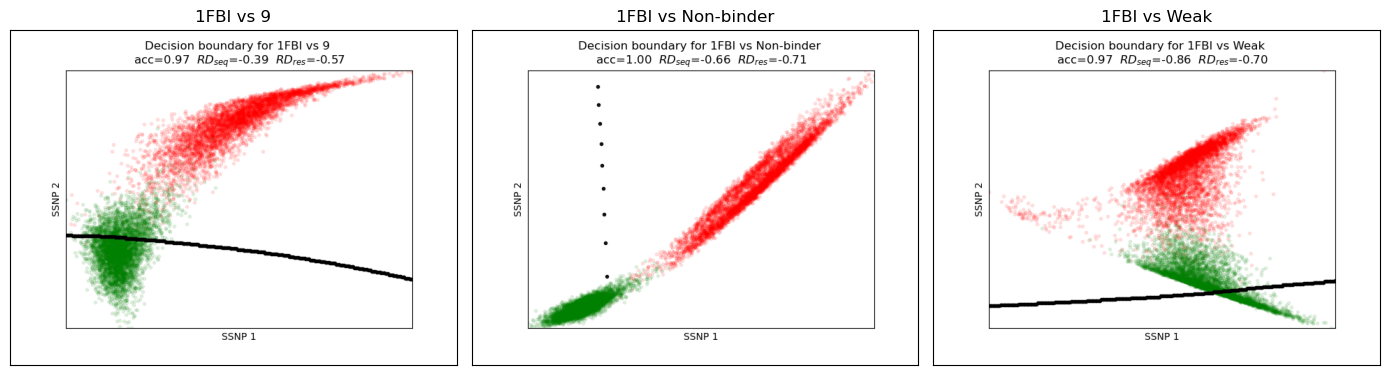

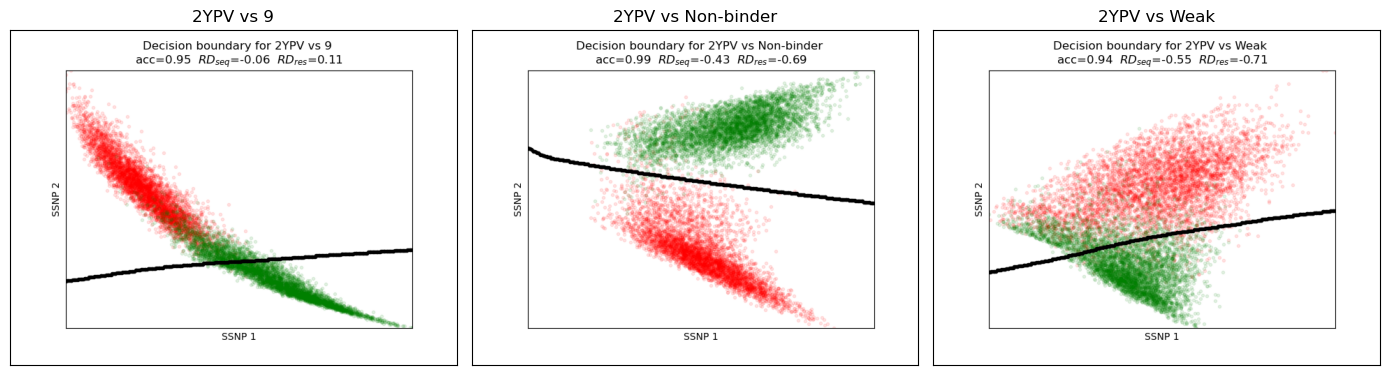

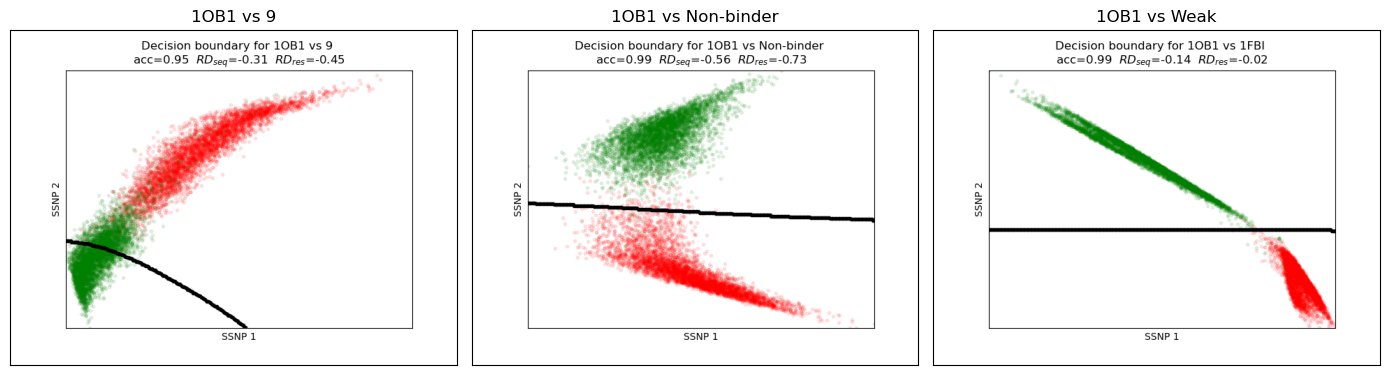

In [8]:
from matplotlib.backends.backend_pdf import PdfPages

plt.rcParams["figure.figsize"] = [7.00, 3.50] 
plt.rcParams["figure.autolayout"] = True

# PdfPages is a wrapper around pdf  
# file so there is no clash and 
# create files with no error. 
p = PdfPages("test3.pdf") 

tasks = list(filter(lambda t: t.seed_id == 0 and t.split_id == 42, tasks))

for ag in config.ANTIGENS:

    tasks_ag = filter(lambda t: t.ag_pos == ag, tasks)

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 7))

    counter_1v1 = 0
    for task in tasks_ag:

        task = loader.load(task)
        base_path = task.basepath
        img_path = base_path / "SDBM/SN10_300x300_SDBM_nice.png"
    
        if img_path.exists():
            img = plt.imread(img_path)

        # Select ax based on task_type
        if task.task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
            continue

        elif task.task_type == datasets.ClassificationTaskType.ONE_VS_NINE:
            ax = axs[0]
            title = f"{task.ag_pos} vs 9"
        elif task.task_type == datasets.ClassificationTaskType.HIGH_VS_95LOW:
            ax = axs[1]
            title = f"{task.ag_pos} vs Non-binder"
        elif task.task_type == datasets.ClassificationTaskType.HIGH_VS_LOOSER:
            ax = axs[2]
            title = f"{task.ag_pos} vs Weak"

        # Figure from img
        ax.imshow(img)
        ax.set_title(title)

    # Make all the unused axes invisible
    for ax in axs.flatten():
        if not ax.get_title():
            ax.axis("off")
        else:
            ax.axis("on")

    # Remove x and y ticks and labels
    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")

    # and saving the files 
    fig.savefig(p, format='pdf')
        
# close the object 
p.close()   